# Homework 03

**Bernard Mwamburi**

## Preparing the Environment

Use the cell below to import NumPy, Pandas, and the Pyplot library of Matplotlib, using the standard aliases. Also import the following tools from Scikit-Learn: `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, `ColumnTransformer`, `Pipeline`, `LogisticRegresion`, `DecisionTreeClassifier`, `cross_val_score`, `cross_val_predict`, `classification_report`, `confusion_matrix`, and `RocCurveDisplay`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

# Part 1: Load and Process Data

In this assignment, you will be working with data from the 1994 US Census. Our goal will be to create a model to predict whether or not an individual has an annual salary greater than $50,000 based on various demographic factors. You can find more information about the dataset, including a description of the features here: [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult). 

Note that the label values are stored in the income column. All other columns represent features. All feature columns containing numerical values represent numerical features and all feature columns containing string values represent categorical features.

Use the cell below to load the dataset `census.csv` into a DataFrame. Shuffle the DataFrame (setting `random_state=1`), print its shape, and then display the head of the DataFrame. 


In [2]:
census = pd.read_csv('census.csv')
census = census.sample(frac=1, random_state=1)
print(census.shape)
census.head()

(32561, 15)


,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
9646,24,Private,336088,HS-grad,9,Divorced,Exec-managerial,Not-in-family,Amer-Indian-Eskimo,Female,0,0,50,United-States,<=50K
709,34,Federal-gov,190228,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,48,United-States,>50K
7385,18,Private,104704,HS-grad,9,Never-married,Adm-clerical,Own-child,Black,Male,0,0,40,United-States,<=50K
16671,44,Private,36271,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21932,27,Private,178709,Masters,14,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K


Use the `value_counts()` method to display a DataFrame showing the proportions of label observations with each class ('<=50K' or '>50K').

In [3]:
census.income.value_counts(normalize=True).to_frame()

,income
<=50K,0.75919
>50K,0.24081


Use the `isnull()` method to display a DataFrame showing the number of missing values in each column. Use the `T` (or transpose) attribute to display the DataFrame as a single row.

In [4]:
census.isnull().sum().to_frame().T

,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
0,0,1836,0,0,0,0,1843,0,0,0,0,0,0,583,0


Create lists (or arrays) containing the names of the numerical and categorical features. Print these lists along with messages indicating which features are numerical and which are categorical. 

In [5]:
census.columns.values

array(['age', 'workclass', 'fnlwgt', 'education', 'educ_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hrs_per_week', 'native_country',
       'income'], dtype=object)

In [6]:
num_features = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hrs_per_week']
cat_features = ['workclass', 'education', 'educ_num', 'marital_status', 'occupation',
                'relationship', 'race', 'sex', 'native_country']
print(f"Numerical features:  {num_features}")
print(f"Categorical featurs: {cat_features}")

Numerical features:  ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hrs_per_week']
Categorical featurs: ['workclass', 'education', 'educ_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


Use the `nunique()` method to display a DataFrame showing the number of levels for each categorical feature. Use the `T` (or transpose) attribute to display the DataFrame as a single row.

In [7]:
census[cat_features].nunique().to_frame().T

,workclass,education,educ_num,marital_status,occupation,relationship,race,sex,native_country
0,8,16,16,7,14,6,5,2,41


Create two `Pipeline` objects, one for the numerical features and another for the categorical features. The numerical feature pipeline should contain a `SimpleImputer` with `strategy='mean'` as well as a `StandardScaler`. The categorical transformer should contain a `SimpleImputer` with `strategy='constant'` and `fill_value='Missing'`, as well as a `OneHotEncoder` with `handle_unknown='ignore'` and `sparse=False`. 

Combine the two pipelines into a `ColumnTransformer`, applying each pipeline to the correct features. 

Then create a label array named `y` and use the `ColumnTransformer` to create a feature array `X`. Print the shape of `X`. 

In [8]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Missing')),
        ('encoder', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

y = census.income
X = preprocessor.fit_transform(census)
print(X.shape)

(32561, 123)


# Part 2: Compare Models

Create a logistic regression model, setting `penalty='none'`. Estimate the model's out-of-sample accuracy using 10-cross validation. Print the result rounded to 4 decimal places in a message of the following form: `"CV Score: ----"`. You might need to adjust the `max_iter` parameter of your model to avoid convergence warnings. Note that you are not asked to actually fit a model on the full dataset at this point. 

In [9]:
log_reg = LogisticRegression(penalty=None, max_iter=1000)
print(f"CV Score: {np.round(cross_val_score(log_reg, X, y, cv=10).mean(), 4)}")

CV Score: 0.8521


Perform the following tasks in the cell below:
1. Create an empty list named `scores`.
2. Create a list named `depth_list` containing potential `max_depth` values to use for a decision tree model. 
3. Loop over the values of `depth_list`. For each iteration of the loop, perform the following steps:
    A. Create a `DecisionTreeClassifier` with the current value for `max_depth` and with `random_state=1`. 
    B. Estimate the out-of-sample accuracy for the model using 10-fold cross-validation.
    C. Append the CV score to the `scores` list. 
4. Use `np.max()` and `np.argmax()` to determine the best CV score obtained, and the value of `max_depth` that produced it. 
5. Print the best score and best hyperparameter value found in Step 4. Add text of the form `"Best CV Score:"` and `"Best Max Depth:"` to explain what the values are. 

After running this, you might need to adjust your depth list to make sure that you are considering a good range of values. Your goal is to find the best possible maximum depth, but also to demonstrate (with reasonable certainty) that this is, in fact, the best possible value. 

In [10]:
scores = []
depth_list = list(range(2, 21, 1))
for dep in depth_list:
    temp_model = DecisionTreeClassifier(max_depth=dep, random_state=1)
    scores.append(cross_val_score(temp_model, X, y, scoring="accuracy", cv=10).mean())

max_value = np.max(scores)
max_idx = np.argmax(scores)

print(f"""
Best CV score:  {np.round(max_value, 4)}
Best Max Depth: {depth_list[max_idx]}
""")


Best CV score:  0.8577
Best Max Depth: 12



Create a plot that shows how the CV-scores vary with the maximum depth. Label the x-axis as "max_depth" and the y-axis as "CV Score". 

Your plot should demonstrate a clear peak in the CV scores. If it does not, please adjust `depth_list` in the previous cell accordingly. 

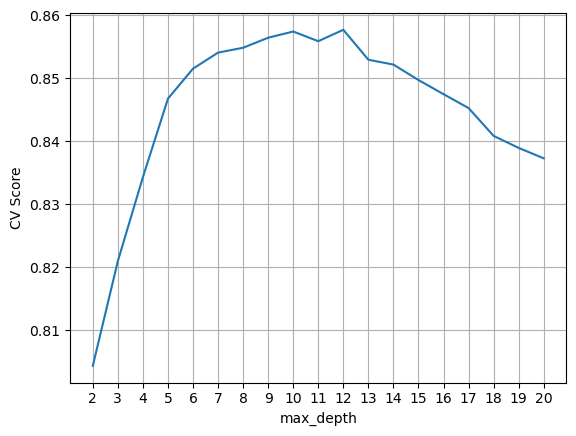

In [11]:
plt.plot(depth_list, scores)
plt.xlabel("max_depth")
plt.ylabel("CV Score")
plt.xticks(depth_list)
plt.grid()
plt.show()

# Part 3: Analyze Final Model

Identify the model with the best CV score, whether that is the logistic regression model, or a decision tree model with a specific value for `max_depth`. Use the cell below to recreate that model, naming it `final_model` (or something similar). Then fit the model to the entire dataset. Finally, print the training accuracy rounded to 4 decimal places. 

In [12]:
final_model = DecisionTreeClassifier(max_depth=depth_list[max_idx], random_state=1)
final_model.fit(X, y)
print(f"Training Accuracy: {np.round(final_model.score(X, y), 4)}")

Training Accuracy: 0.881


Use `cross_val_score()` to estimate the out-of-sample accuracy and the out-of-sample AUC scores for the final model. Print both scores rounded to 4 decimal places, and with text indicating what the values represent. 

In [13]:
print(f"""
CV Accuracy:  {np.round(cross_val_score(final_model, X, y, scoring='accuracy', cv=10).mean(), 4)}
CV AUC:       {np.round(cross_val_score(final_model, X, y, scoring='roc_auc').mean(), 4)}
""")


CV Accuracy:  0.8577
CV AUC:       0.8809



Use `cross_val_predict()` to generate out-of-sample class predictions as well as out-of-sample class probability estimates. Use 10-fold CV in both cases and store the results in arrays. Print the shapes of the two arrays. 

In [14]:
cv_predict = cross_val_predict(final_model, X, y, cv=10)
cv_predict_proba = cross_val_predict(final_model, X, y, cv=10, method='predict_proba')

print(cv_predict.shape)
print(cv_predict_proba.shape)

(32561,)
(32561, 2)


Use the out-of-sample class predictions to create a confusion matrix. Display the confusion matrix as a DataFrame, with rows and columns labeled `'<=50K'` and `'>50K'`. 


In [15]:
cm = confusion_matrix(y, cv_predict)
pd.DataFrame(cm, columns=['<=50K', '>50K'], index=['<=50K', '>50K'])

,<=50K,>50K
<=50K,23221,1499
>50K,3134,4707


Use the out-of-sample class predictions to create and print a classification report. 

In [16]:
print(classification_report(y, cv_predict))

              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91     24720
        >50K       0.76      0.60      0.67      7841

    accuracy                           0.86     32561
   macro avg       0.82      0.77      0.79     32561
weighted avg       0.85      0.86      0.85     32561



Use the out-of-sample class probability estimates to dispay an ROC curve. You will need to set `pos_label='>50K'`. 

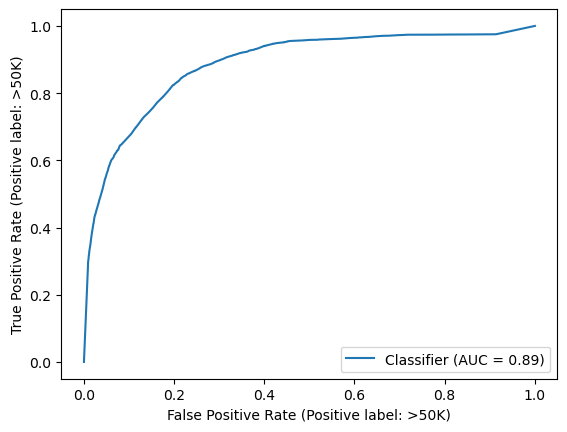

In [17]:
roc_curve = RocCurveDisplay.from_predictions(y, cv_predict_proba[:, 1], pos_label='>50K')

In the cell below, you will determine the classification threshold that will result in a recall of at least 0.8 for the label `'>50K'`. Partial code has been provided for you. You need to do the following:
1. Set a value for `t`.
2. Set the indices for `cv_prob` to select the estimated probabilities for the label `'>50K'`. 
3. Adjust the values of `t` so that the recall for `'>50K'` is at least 0.8, but is also as close as posible to 0.8.

In [18]:
t = 0.3

adj_pred = np.where(cv_predict_proba[:,1]<t, '<=50K', '>50K')
print(classification_report(y, adj_pred))

              precision    recall  f1-score   support

       <=50K       0.93      0.82      0.87     24720
        >50K       0.59      0.79      0.67      7841

    accuracy                           0.82     32561
   macro avg       0.76      0.81      0.77     32561
weighted avg       0.84      0.82      0.82     32561



# Part 4: Applying the Model to New Observations

We will now apply our final model to a new set of observations. The new observations are stored in the CSV file `census_new.csv`. Load these observations into a new DataFrame. Print the shape of the DataFrame and display it. **Do not shuffle the DataFrame.**

In [19]:
df = pd.read_csv('census_new.csv')
print(df.shape)
df

(10, 14)


,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country
0,33,Private,229466,Bachelors,9,Married-civ-spouse,NaN,Not-in-family,White,Male,0,0,40.0,United-States
1,48,Private,366324,5th-6th,3,Married-spouse-absent,Handlers-cleaners,Not-in-family,White,Male,0,0,NaN,United-States
2,24,Self-emp-not-inc,312017,HS-grad,10,Divorced,Handlers-cleaners,Not-in-family,Black,Male,3464,0,60.0,United-States
3,24,Private,160634,Assoc-voc,13,Widowed,Sales,Husband,White,Female,0,0,50.0,United-States
4,62,Private,125457,Some-college,13,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,45.0,United-States
5,31,Private,153183,Bachelors,6,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,70.0,United-States
6,36,Self-emp-not-inc,102308,Assoc-voc,10,Never-married,Machine-op-inspct,Husband,White,Male,8614,1977,40.0,United-States
7,42,Local-gov,397317,Bachelors,7,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States
8,25,Private,289886,Bachelors,11,Divorced,Adm-clerical,Husband,White,Male,0,0,40.0,United-States
9,22,NaN,386378,11th,9,Never-married,NaN,Husband,White,Female,0,0,40.0,United-States


In the cell below, apply the `ColumnTransformer` object you created previously to the new data, storing the results in an array. Print the shape of this array. 

In [20]:
X_new = preprocessor.transform(df)
X_new.shape

(10, 123)

Use your final model to generate class predictions for the new observations. Print those predictions. 

In [21]:
predictions = final_model.predict(X_new)
print(predictions)

['<=50K' '<=50K' '<=50K' '<=50K' '>50K' '<=50K' '>50K' '<=50K' '<=50K'
 '<=50K']


Use your final model to generate class probability estimates for the new observations. Print those estimates. 

In [22]:
probabilities = final_model.predict_proba(X_new)
print(probabilities)

[[8.40032814e-01 1.59967186e-01]
 [9.80815348e-01 1.91846523e-02]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [3.21561338e-01 6.78438662e-01]
 [6.66666667e-01 3.33333333e-01]
 [0.00000000e+00 1.00000000e+00]
 [9.80815348e-01 1.91846523e-02]
 [9.99379653e-01 6.20347395e-04]
 [9.99379653e-01 6.20347395e-04]]
